## Progetto Process Monitoring

Dataset: https://www.kaggle.com/datasets/vinayak123tyagi/bearing-dataset

Piattaforma: https://github.com/amazon-science/chronos-forecasting

#### Librerie da importare

In [1]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os

#### PIPELINE Chronos

In [2]:
# Lista delle pipeline

# Tiny
pipeline_tiny = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Mini
pipeline_mini = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-mini",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Small
pipeline_small = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Base
pipeline_base = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

# Large
pipeline_large = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

#### Processamento dati

In [3]:
# Parametri
PATH_SET1 = "archive/1st_test/1st_test"
PATH_SET2 = "archive/2nd_test/2nd_test"
PATH_SET3 = "archive/3rd_test/4th_test/txt"

NUM_ROWS = 20480

NUM_FILES1 = 2150
NUM_FILES2 = 980
NUM_FILES3 = 6300

NUM_TEST = 64
NUM_SAMPLES = 32

def load_and_normalize_data(path, num_rows, num_files):
    file_list = sorted(os.listdir(path))[:num_files]
    data = []
    for file_name in file_list:
        try:
            file_path = os.path.join(path, file_name)
            df = pd.read_csv(file_path, header=None, delimiter="\t", nrows=num_rows)
            data.append(df.astype(float).values)
        except Exception as e:
            print(f"Error loading file {file_name}: {e}")
    data = np.vstack(data)
    
    scaler = MinMaxScaler()
    data_normalized = scaler.fit_transform(data)
    
    return data_normalized

# Carica e normalizza i dati per il set 1
data1 = load_and_normalize_data(PATH_SET1, num_rows=NUM_ROWS, num_files=NUM_FILES1)
train_data1 = data1[:-NUM_TEST]
test_data1 = data1[-NUM_TEST:]

# Carica e normalizza i dati per il set 2
data2 = load_and_normalize_data(PATH_SET2, num_rows=NUM_ROWS, num_files=NUM_FILES2)
train_data2 = data2[:-NUM_TEST]
test_data2 = data2[-NUM_TEST:]

# Carica e normalizza i dati per il set 3
data3 = load_and_normalize_data(PATH_SET3, num_rows=NUM_ROWS, num_files=NUM_FILES3)
train_data3 = data3[:-NUM_TEST]
test_data3 = data3[-NUM_TEST:]

## USO LE PIPELINE SUL SET 1

#### PIPELINE TINY

Mean Absolute Error (MAE) per canale:
Channel 1: 0.06829490711483986
Channel 2: 0.04578877986602447
Channel 3: 0.07588012777214563
Channel 4: 0.07520722460120599
Channel 5: 0.020815134496041852
Channel 6: 0.03280354088445764
Channel 7: 0.020947070026238957
Channel 8: 0.02250598741159432

Mean Squared Error (MSE) per canale:
Channel 1: 0.0077782325576767125
Channel 2: 0.003589545984868561
Channel 3: 0.009114458392116402
Channel 4: 0.008117746588679038
Channel 5: 0.0006571758919242725
Channel 6: 0.001595816378719412
Channel 7: 0.0007577786535201951
Channel 8: 0.0008517119101872526


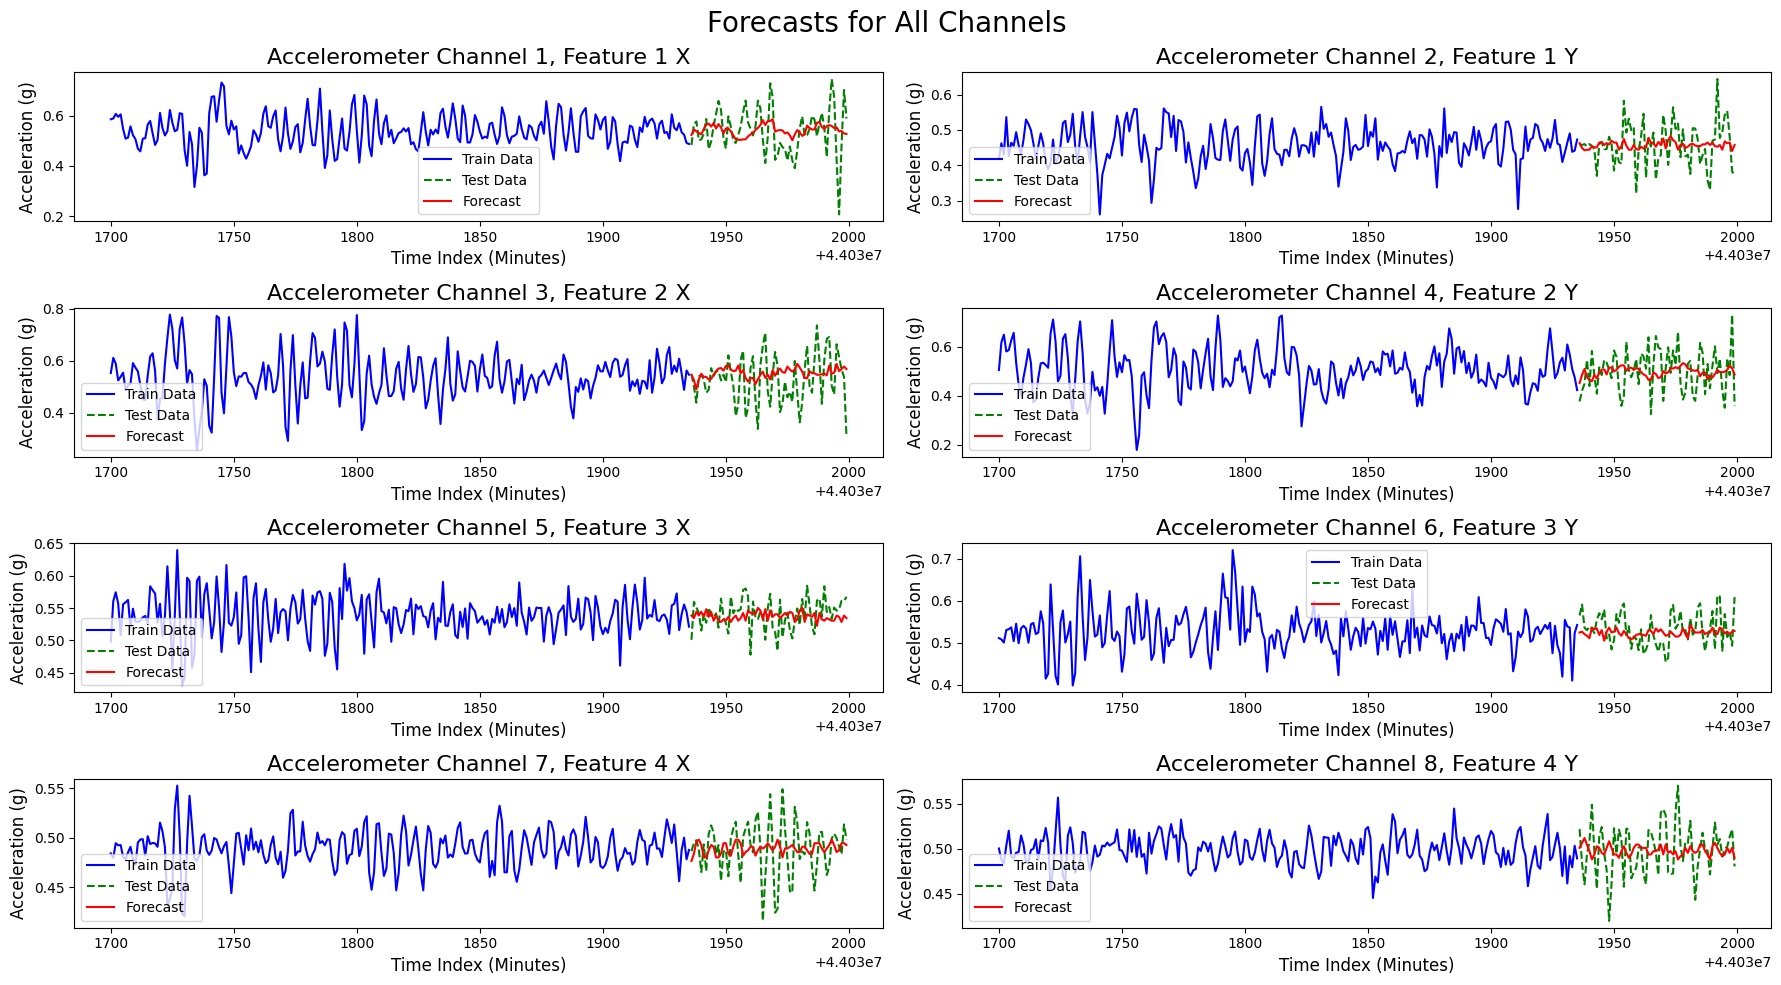

In [4]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data1).float().T

# Esegui il forecasting
forecast_segment = pipeline_tiny.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data1

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")

def plot_forecast_all_channels(train_data, test_data, forecasts):
    n_train_points = 236
    n_test_points = NUM_TEST

    train_data_last = train_data[-n_train_points:].T
    test_data_t = test_data.T
    median_forecasts_t = np.median(forecasts, axis=1)

    x_train = np.arange(len(train_data) - n_train_points, len(train_data))
    x_test = np.arange(len(train_data), len(train_data) + n_test_points)

    channel_labels = [
        "Accelerometer Channel 1",
        "Accelerometer Channel 2",
        "Accelerometer Channel 3",
        "Accelerometer Channel 4",
        "Accelerometer Channel 5",
        "Accelerometer Channel 6",
        "Accelerometer Channel 7",
        "Accelerometer Channel 8"
    ]

    fig, axs = plt.subplots(4, 2, figsize=(18, 10))
    fig.suptitle('Forecasts for All Channels', fontsize=20)

    for i in range(4):  # Per ogni cuscinetto
        for j in range(2):  # Per asse X e Y
            channel_index = i * 2 + j
            ax = axs[i, j]
            
            ax.plot(x_train, train_data_last[channel_index], label='Train Data', color='blue')
            ax.plot(x_test, test_data_t[channel_index], label='Test Data', linestyle='dashed', color='green')
            ax.plot(x_test, median_forecasts_t[channel_index], label='Forecast', color='red')

            # Imposta il titolo e leggenda
            ax.set_title(f"{channel_labels[channel_index]}, Feature {(channel_index // 2) + 1} {'X' if j % 2 == 0 else 'Y'}", fontsize=16)
            ax.legend()
            ax.set_xlabel('Time Index (Minutes)', fontsize=12)
            ax.set_ylabel('Acceleration (g)', fontsize=12)

    plt.tight_layout()
    plt.show()

# Crea i grafici per tutti i canali
plot_forecast_all_channels(train_data1, test_data1, forecasts)

#### PIPELINE MINI

Mean Absolute Error (MAE) per canale:
Channel 1: 0.07055457127165654
Channel 2: 0.04958453271930667
Channel 3: 0.07683631229683352
Channel 4: 0.07468725904811026
Channel 5: 0.018258272002648873
Channel 6: 0.034896093840249144
Channel 7: 0.019122577589250036
Channel 8: 0.02189991943945116

Mean Squared Error (MSE) per canale:
Channel 1: 0.008385702688050601
Channel 2: 0.0038128995460006048
Channel 3: 0.009149562453823127
Channel 4: 0.008277221677400831
Channel 5: 0.0005189346374108491
Channel 6: 0.0017714744945057357
Channel 7: 0.0006491952720286755
Channel 8: 0.0007702623772558675


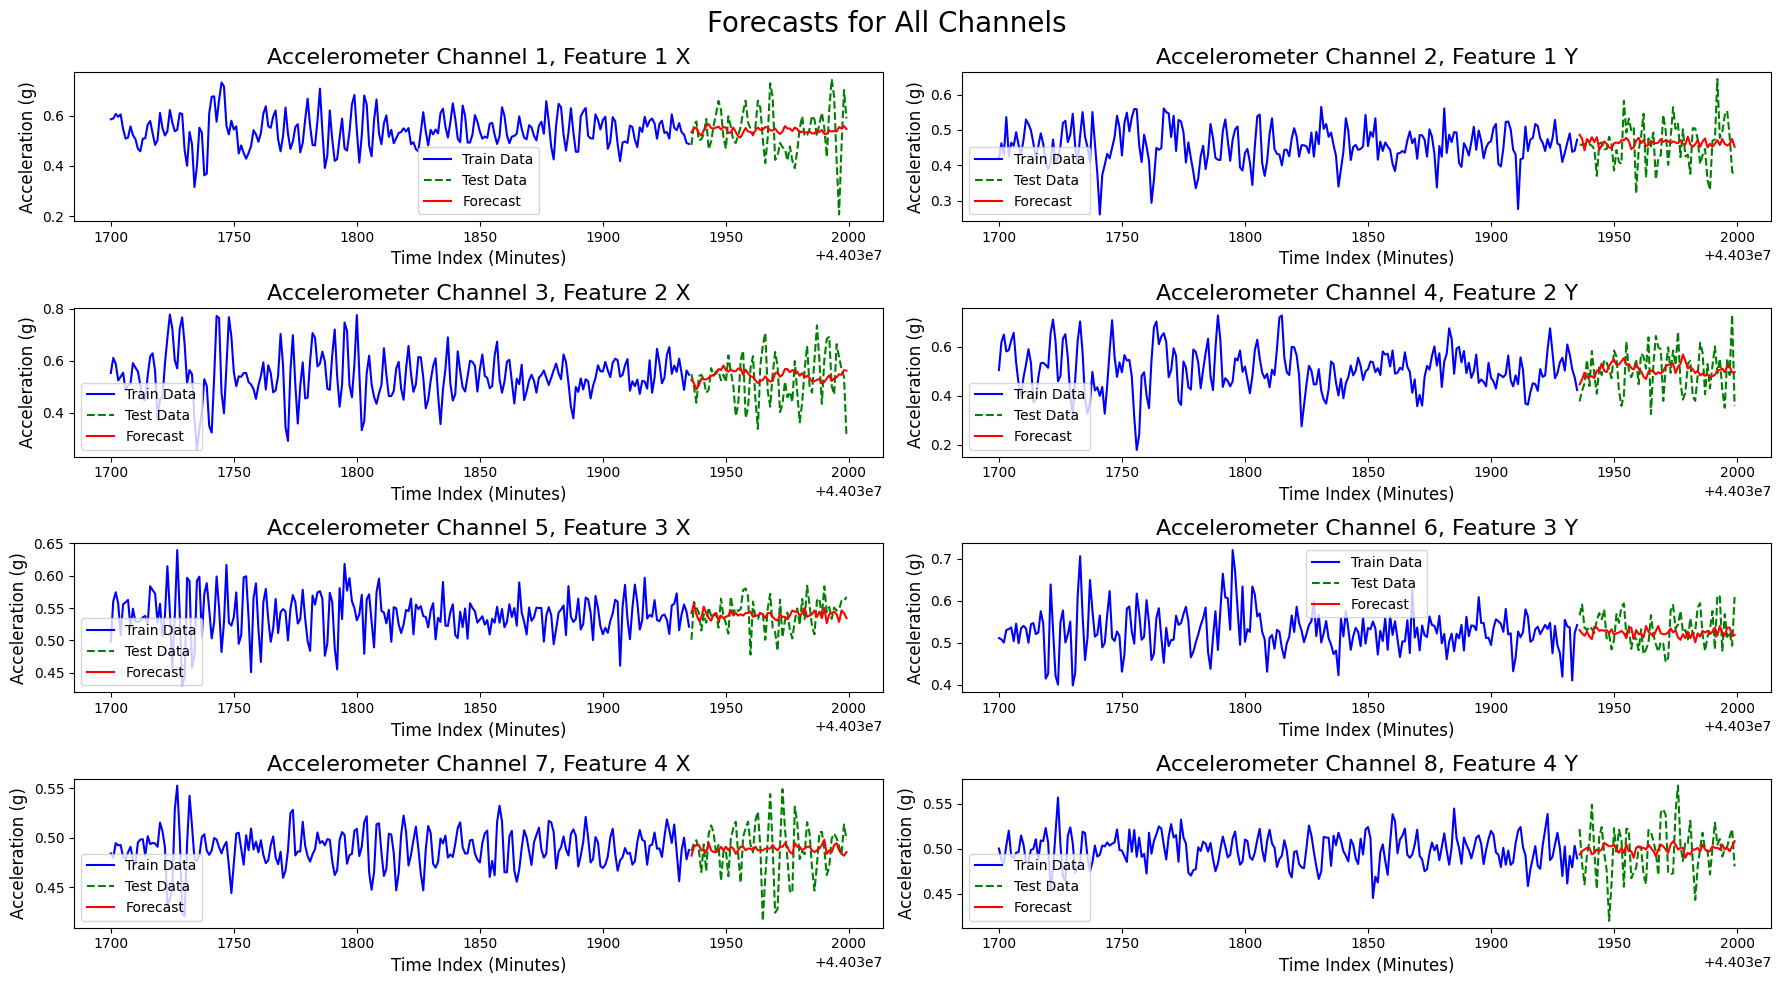

In [5]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data1).float().T

# Esegui il forecasting
forecast_segment = pipeline_mini.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data1

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")

# Crea i grafici per tutti i canali
plot_forecast_all_channels(train_data1, test_data1, forecasts)

#### PIPELINE SMALL

Mean Absolute Error (MAE) per canale:
Channel 1: 0.07288053543192008
Channel 2: 0.04837035927533299
Channel 3: 0.08093506905623868
Channel 4: 0.07218727115881389
Channel 5: 0.019154488157233286
Channel 6: 0.031854739065463294
Channel 7: 0.020376026828247337
Channel 8: 0.021635707264331228

Mean Squared Error (MSE) per canale:
Channel 1: 0.008718535821770453
Channel 2: 0.00384912339122437
Channel 3: 0.0102597312745233
Channel 4: 0.007726127715086905
Channel 5: 0.000579209884258036
Channel 6: 0.0014989099047714146
Channel 7: 0.000719623373859435
Channel 8: 0.000725068232889601


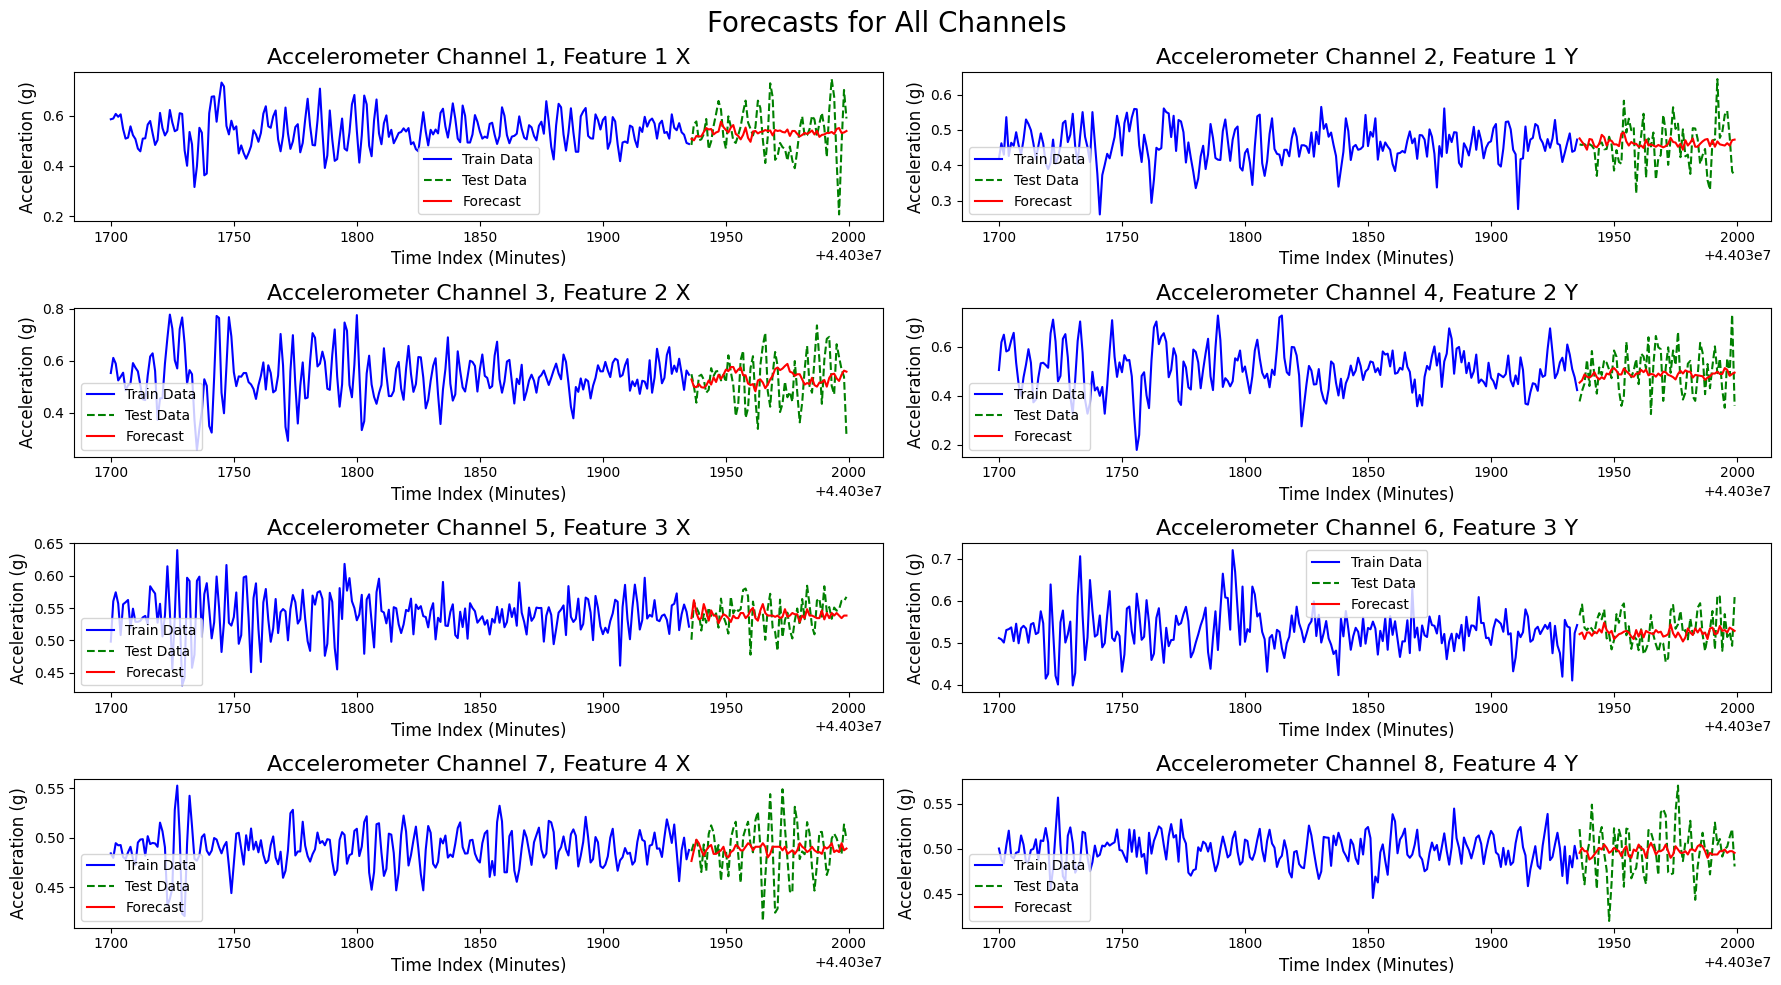

In [6]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data1).float().T

# Esegui il forecasting
forecast_segment = pipeline_small.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data1

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")

# Crea i grafici per tutti i canali
plot_forecast_all_channels(train_data1, test_data1, forecasts)

#### PIPELINE BASE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.07242683060702343
Channel 2: 0.049075766550602015
Channel 3: 0.0806578967617058
Channel 4: 0.07137029023705146
Channel 5: 0.018307978386598735
Channel 6: 0.03208642439074121
Channel 7: 0.019500477236252936
Channel 8: 0.022451086671980383

Mean Squared Error (MSE) per canale:
Channel 1: 0.009345988253771913
Channel 2: 0.0039829777492838055
Channel 3: 0.009647265326260535
Channel 4: 0.0074425608210489805
Channel 5: 0.0005355205812372234
Channel 6: 0.0016377810574497286
Channel 7: 0.0006602014942728307
Channel 8: 0.0008065701705283775


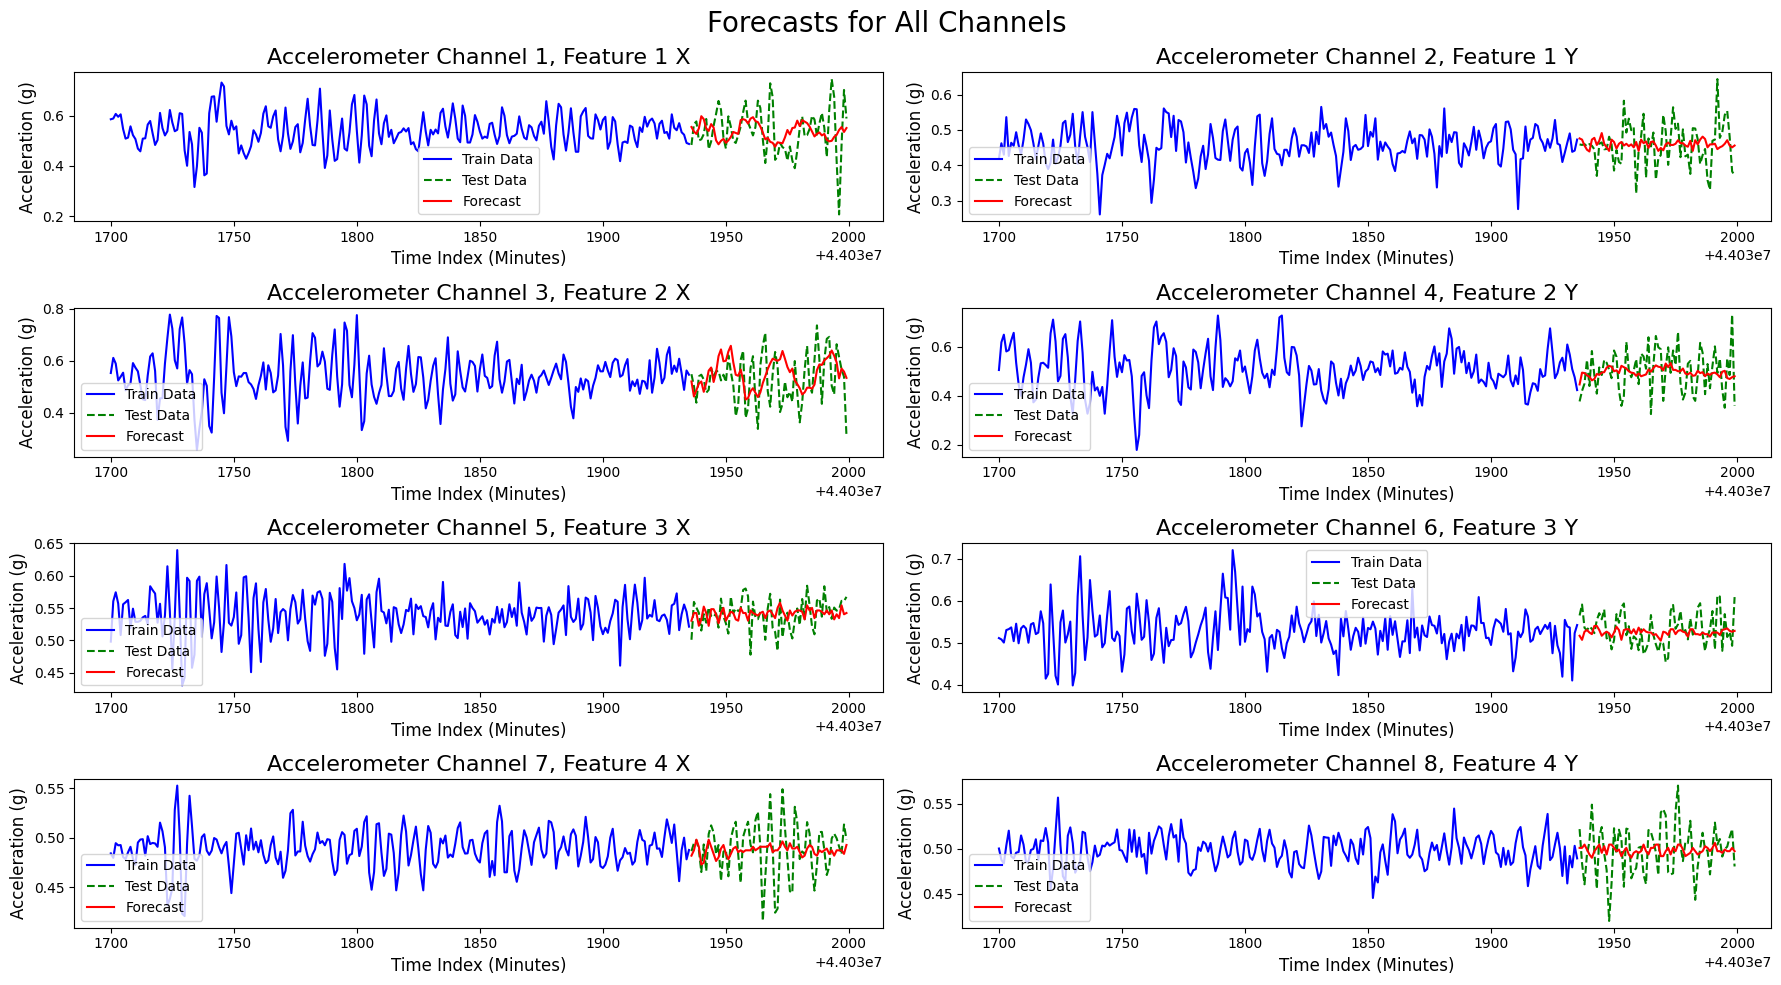

In [7]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data1).float().T

# Esegui il forecasting
forecast_segment = pipeline_base.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data1

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")

# Crea i grafici per tutti i canali
plot_forecast_all_channels(train_data1, test_data1, forecasts)

#### PIPELINE LARGE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.07034513524482885
Channel 2: 0.046893191570173444
Channel 3: 0.07767558508725839
Channel 4: 0.06969562659498676
Channel 5: 0.0191110857442727
Channel 6: 0.03228606431242976
Channel 7: 0.01924312714902543
Channel 8: 0.023439355362085836

Mean Squared Error (MSE) per canale:
Channel 1: 0.008402860341736776
Channel 2: 0.0038416922001981765
Channel 3: 0.009472914611266012
Channel 4: 0.007329708492099517
Channel 5: 0.0005748421252657905
Channel 6: 0.0016137595635666495
Channel 7: 0.0006598878687587136
Channel 8: 0.0008652274039366998


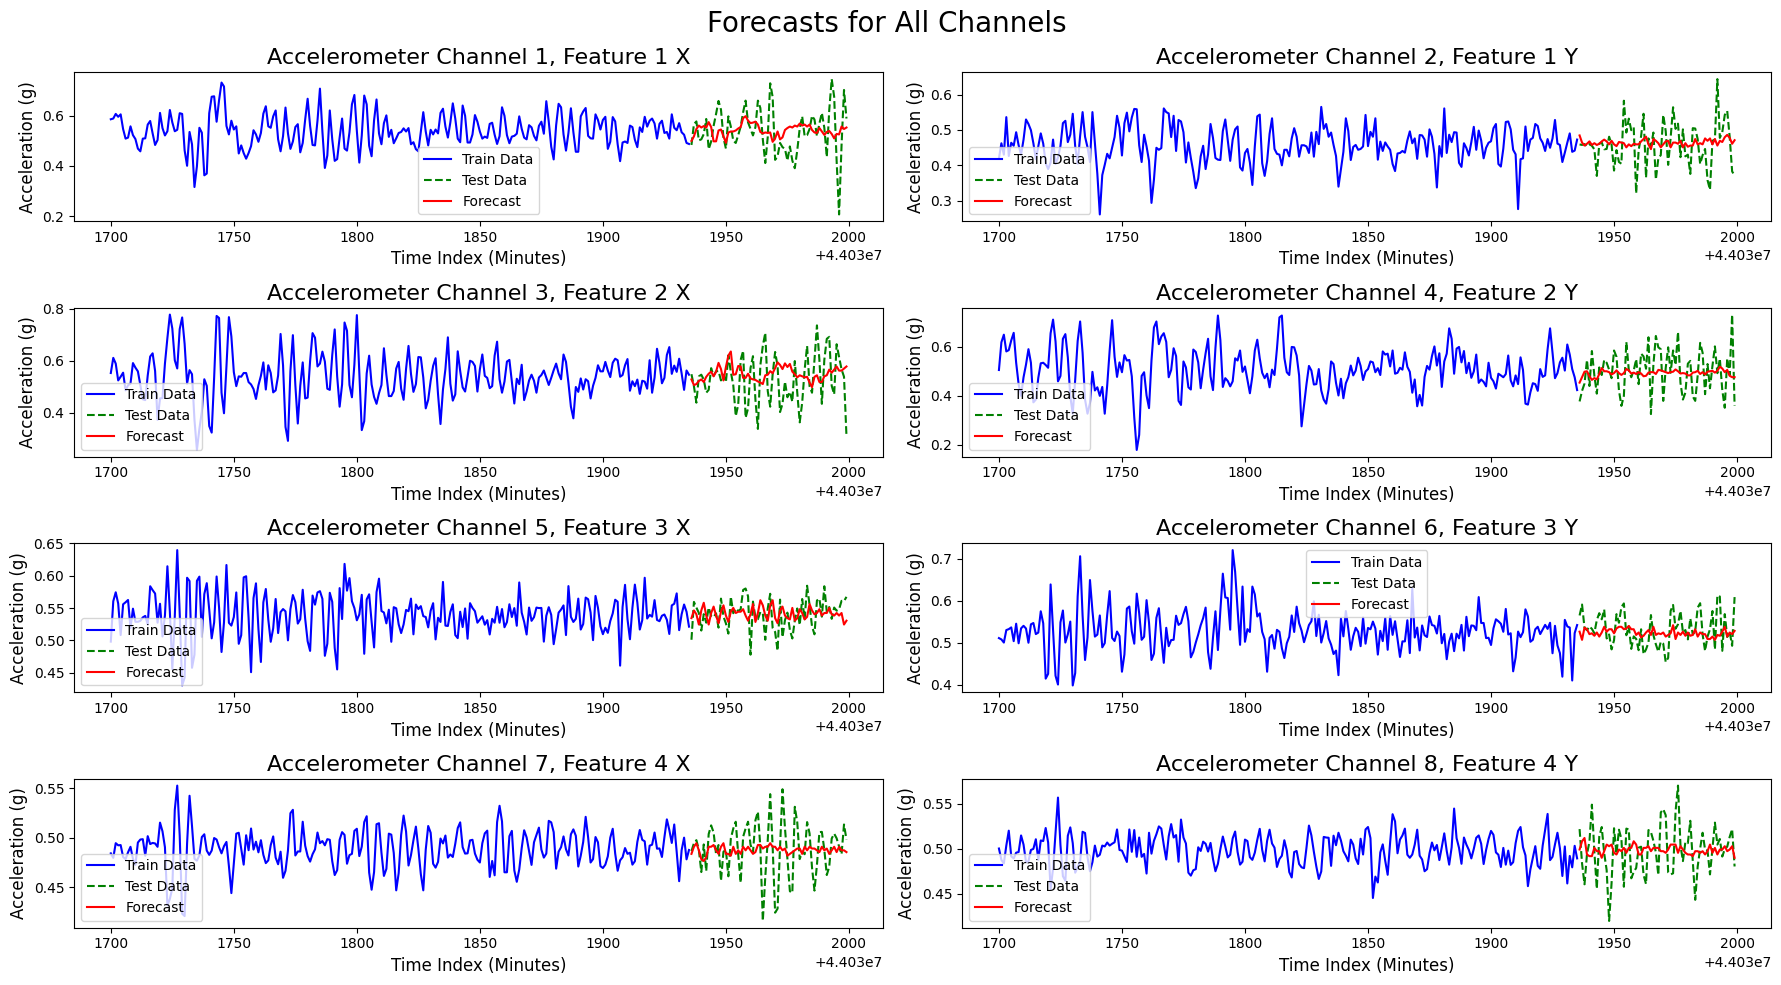

In [8]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data1).float().T

# Esegui il forecasting
forecast_segment = pipeline_large.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data1

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")

# Crea i grafici per tutti i canali
plot_forecast_all_channels(train_data1, test_data1, forecasts)

## USO LE PIPELINE SUL SET 2

#### PIPELINE TINY

Mean Absolute Error (MAE) per canale:
Channel 1: 0.02997787439516423
Channel 2: 0.07892869427785293
Channel 3: 0.050444827227097803
Channel 4: 0.09773992844886563

Mean Squared Error (MSE) per canale:
Channel 1: 0.0014591698310653708
Channel 2: 0.010056824367415909
Channel 3: 0.004304120558624216
Channel 4: 0.01533650856277009


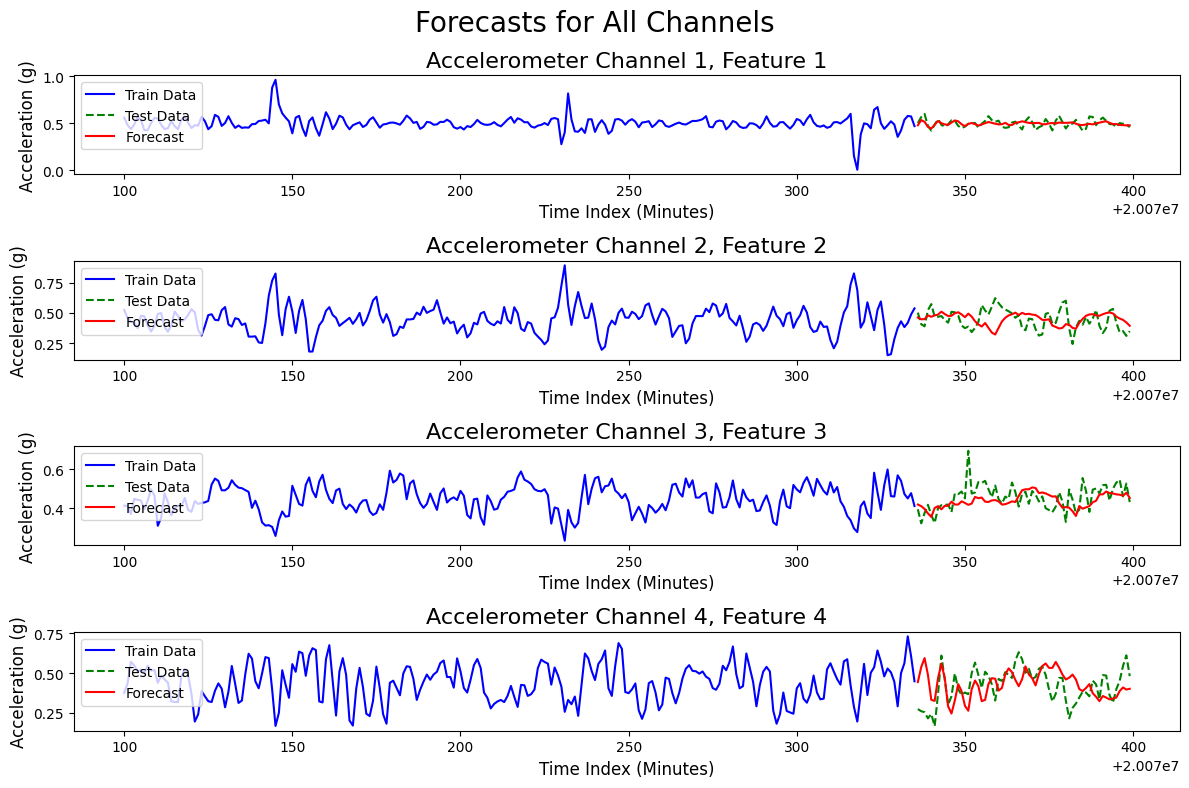

In [9]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data2).float().T

# Esegui il forecasting
forecast_segment = pipeline_tiny.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data2

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


def plot_forecast_all_channels_single(train_data, test_data, forecasts):
    n_train_points = 236
    n_test_points = NUM_TEST

    train_data_last = train_data[-n_train_points:].T
    test_data_t = test_data.T
    median_forecasts_t = np.median(forecasts, axis=1)

    x_train = np.arange(len(train_data) - n_train_points, len(train_data))
    x_test = np.arange(len(train_data), len(train_data) + n_test_points)

    channel_labels = [
        "Accelerometer Channel 1",
        "Accelerometer Channel 2",
        "Accelerometer Channel 3",
        "Accelerometer Channel 4",
    ]

    fig, axs = plt.subplots(4, figsize=(12, 8))
    fig.suptitle('Forecasts for All Channels', fontsize=20)

    for i in range(4):  # Per ogni cuscinetto
        channel_index = i
        ax = axs[i]
        
        ax.plot(x_train, train_data_last[channel_index], label='Train Data', color='blue')
        ax.plot(x_test, test_data_t[channel_index], label='Test Data', linestyle='dashed', color='green')
        ax.plot(x_test, median_forecasts_t[channel_index], label='Forecast', color='red')

        # Imposta il titolo e leggenda
        ax.set_title(f"{channel_labels[channel_index]}, Feature {channel_index + 1}", fontsize=16)
        ax.legend()
        ax.set_xlabel('Time Index (Minutes)', fontsize=12)
        ax.set_ylabel('Acceleration (g)', fontsize=12)

    plt.tight_layout()
    plt.show()


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data2, test_data2, forecasts)

#### PIPELINE MINI

Mean Absolute Error (MAE) per canale:
Channel 1: 0.030708201933327246
Channel 2: 0.061750360979483665
Channel 3: 0.06397944470404063
Channel 4: 0.07398313531394368

Mean Squared Error (MSE) per canale:
Channel 1: 0.0014391631716484715
Channel 2: 0.005906281653043978
Channel 3: 0.0057220534316683
Channel 4: 0.008708333377201092


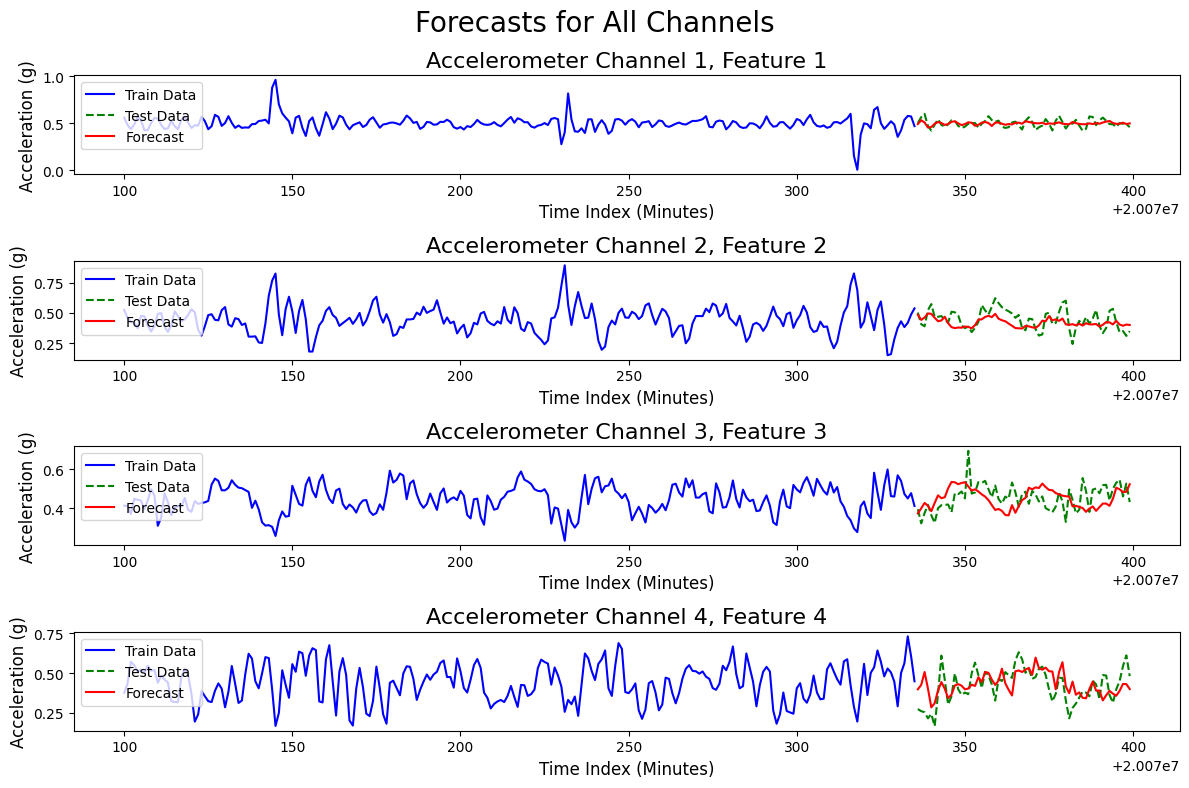

In [10]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data2).float().T

# Esegui il forecasting
forecast_segment = pipeline_mini.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data2

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data2, test_data2, forecasts)

#### PIPELINE SMALL

Mean Absolute Error (MAE) per canale:
Channel 1: 0.026855476928834235
Channel 2: 0.06431186159227889
Channel 3: 0.04547808103547715
Channel 4: 0.06908257763083064

Mean Squared Error (MSE) per canale:
Channel 1: 0.0011653587121602492
Channel 2: 0.00611009447154597
Channel 3: 0.0035380440521830324
Channel 4: 0.0077325977757298405


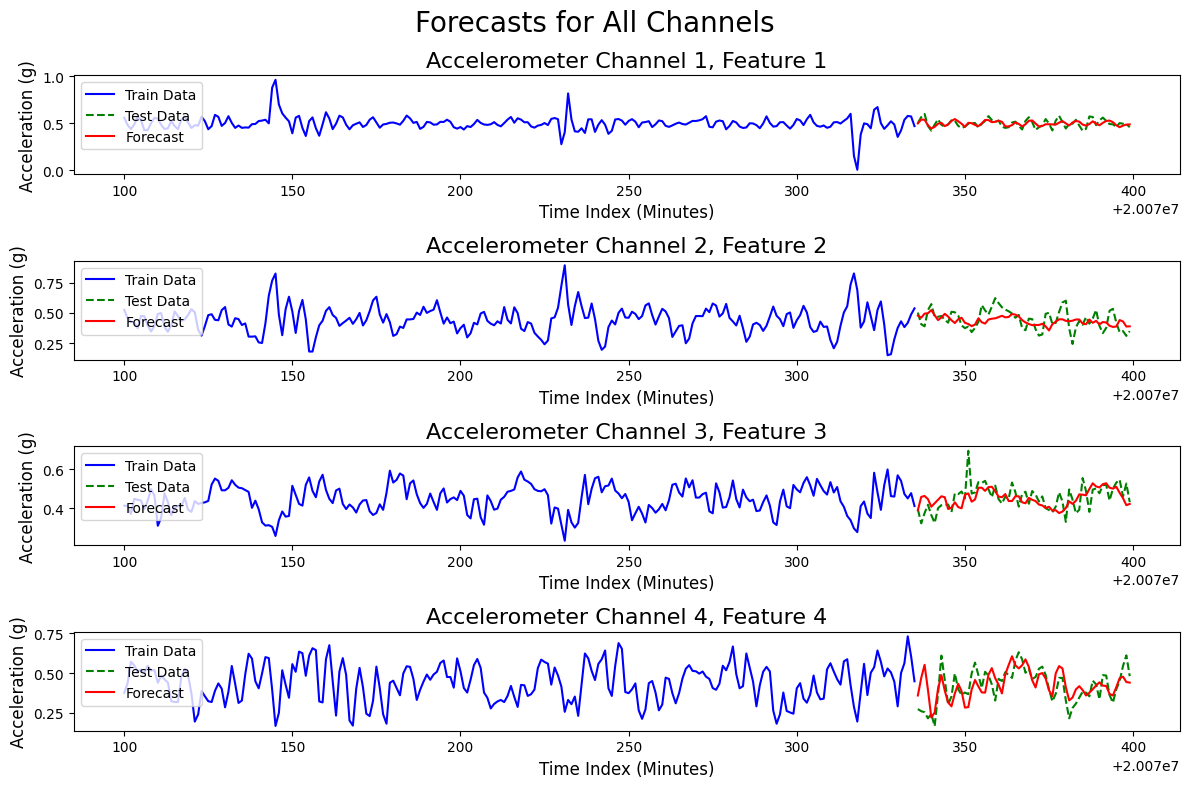

In [11]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data2).float().T

# Esegui il forecasting
forecast_segment = pipeline_small.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data2

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data2, test_data2, forecasts)

#### PIPELINE BASE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.018850205045016073
Channel 2: 0.05843233550293046
Channel 3: 0.054390626706893
Channel 4: 0.06002009499952808

Mean Squared Error (MSE) per canale:
Channel 1: 0.0005432398661433364
Channel 2: 0.005810819248753545
Channel 3: 0.005031183023922142
Channel 4: 0.0056193774089630215


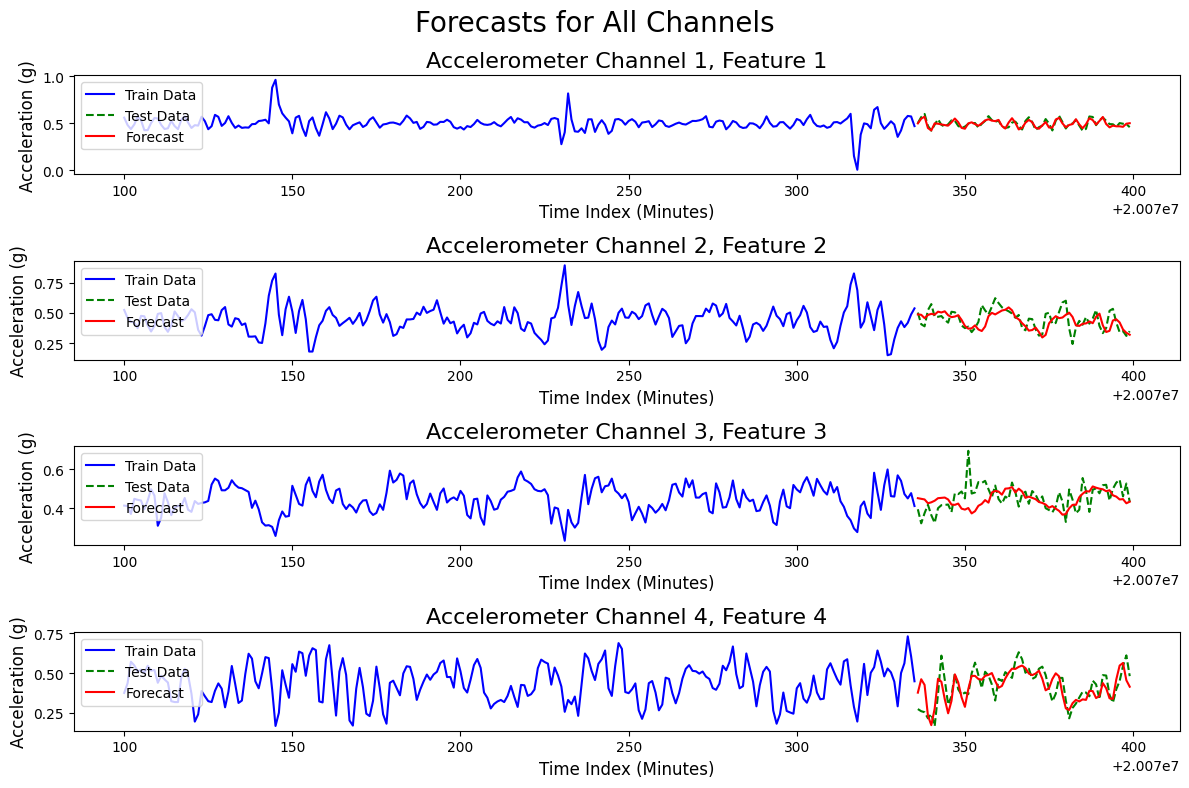

In [12]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data2).float().T

# Esegui il forecasting
forecast_segment = pipeline_base.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data2

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data2, test_data2, forecasts)

#### PIPELINE LARGE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.02120545701162711
Channel 2: 0.053267101280867576
Channel 3: 0.048337062469387605
Channel 4: 0.0762064894778455

Mean Squared Error (MSE) per canale:
Channel 1: 0.0007117605785300841
Channel 2: 0.004454447572364145
Channel 3: 0.004044334553860978
Channel 4: 0.009097073430886258


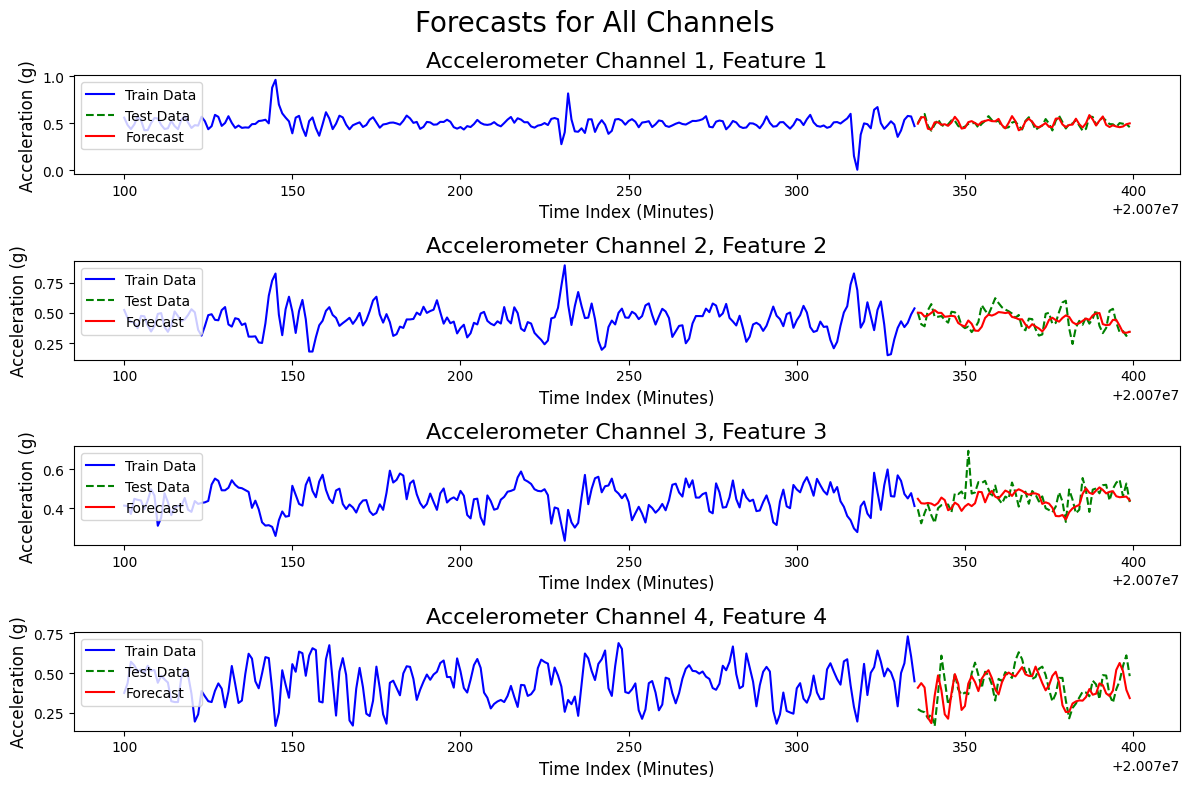

In [13]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data2).float().T

# Esegui il forecasting
forecast_segment = pipeline_large.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data2

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data2, test_data2, forecasts)

## USO LE PIPELINE SUL SET 3

#### PIPELINE TINY

Mean Absolute Error (MAE) per canale:
Channel 1: 0.053235748444257526
Channel 2: 0.08362155641367691
Channel 3: 0.07505743142591469
Channel 4: 0.08517890538926581

Mean Squared Error (MSE) per canale:
Channel 1: 0.004887704622544245
Channel 2: 0.010963590311475823
Channel 3: 0.008448060384448904
Channel 4: 0.01166954804531656


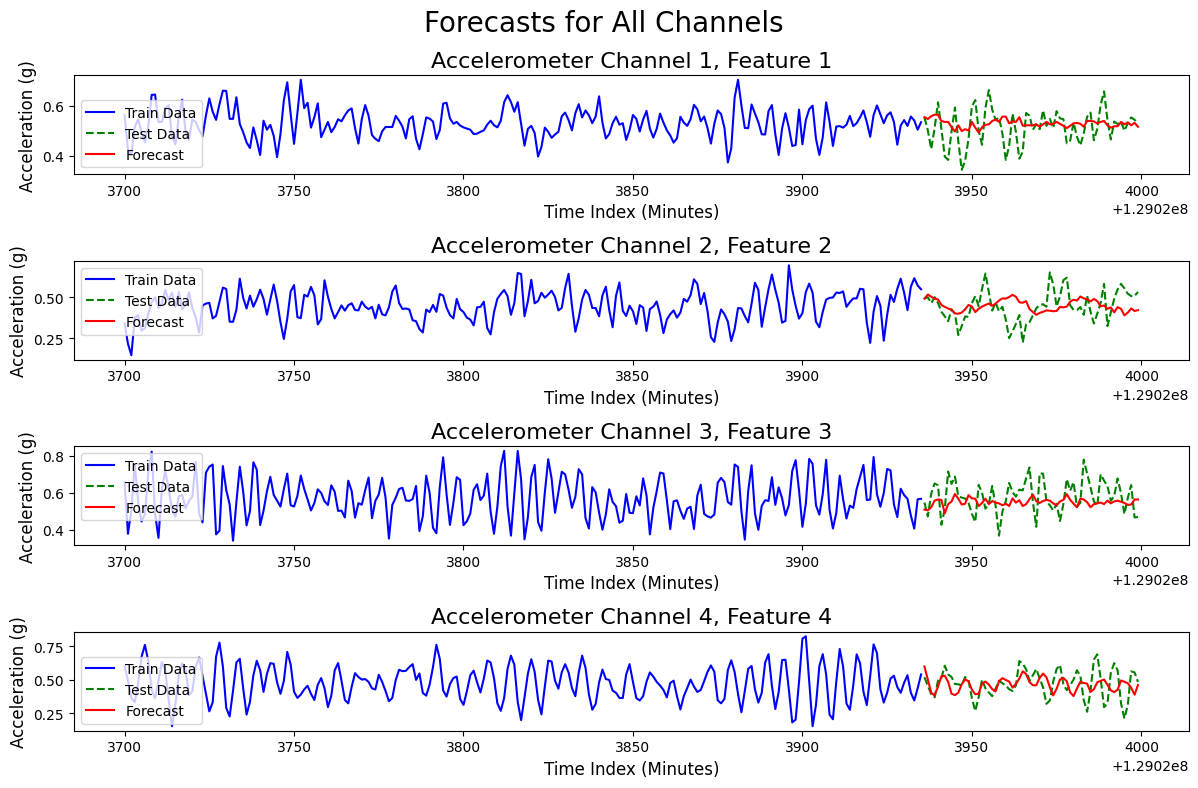

In [14]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data3).float().T

# Esegui il forecasting
forecast_segment = pipeline_tiny.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data3

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data3, test_data3, forecasts)

#### PIPELINE MINI

Mean Absolute Error (MAE) per canale:
Channel 1: 0.057500697374124304
Channel 2: 0.08055523614346397
Channel 3: 0.07199654060501406
Channel 4: 0.07238239992070217

Mean Squared Error (MSE) per canale:
Channel 1: 0.005458558622008131
Channel 2: 0.010231061909894774
Channel 3: 0.00819237743023061
Channel 4: 0.008819091961855596


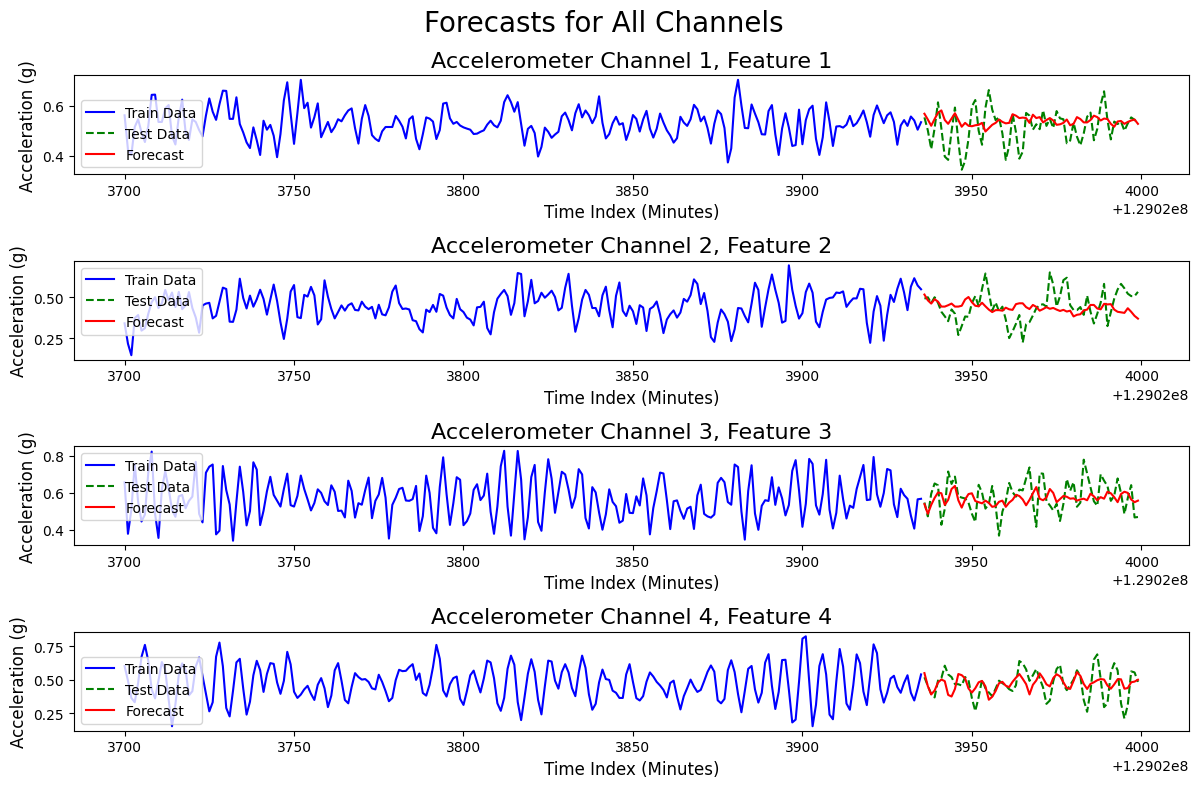

In [15]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data3).float().T

# Esegui il forecasting
forecast_segment = pipeline_mini.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data3

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data3, test_data3, forecasts)

#### PIPELINE SMALL

Mean Absolute Error (MAE) per canale:
Channel 1: 0.054315014864905406
Channel 2: 0.06120346751992666
Channel 3: 0.08964851884341048
Channel 4: 0.07324559888626749

Mean Squared Error (MSE) per canale:
Channel 1: 0.004924788886688123
Channel 2: 0.006565991966221751
Channel 3: 0.012730714562679688
Channel 4: 0.008479272701493108


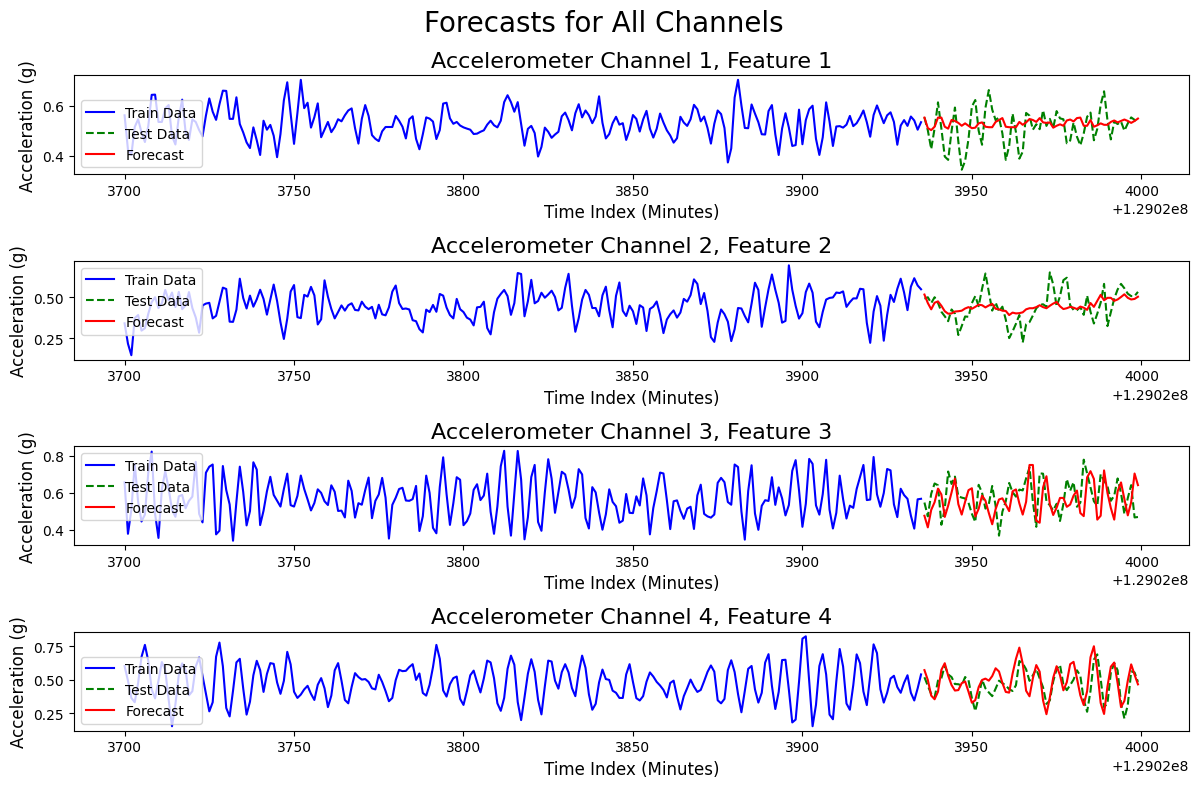

In [16]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data3).float().T

# Esegui il forecasting
forecast_segment = pipeline_small.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data3

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data3, test_data3, forecasts)

#### PIPELINE BASE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.053831397069065534
Channel 2: 0.051353975798025656
Channel 3: 0.06429412456491565
Channel 4: 0.06726177751215515

Mean Squared Error (MSE) per canale:
Channel 1: 0.005060271627154606
Channel 2: 0.004050975633778098
Channel 3: 0.006765678901019136
Channel 4: 0.006927185684729047


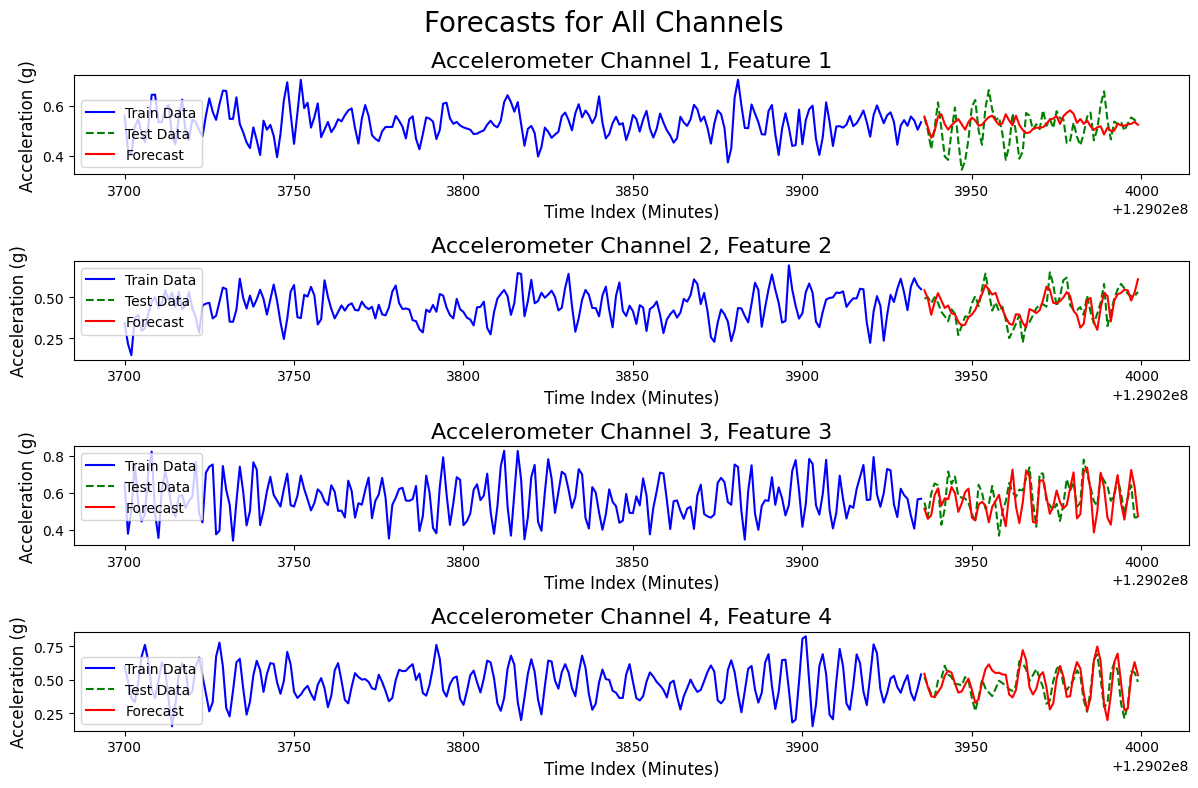

In [17]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data3).float().T

# Esegui il forecasting
forecast_segment = pipeline_base.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data3

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data3, test_data3, forecasts)

#### PIPELINE LARGE

Mean Absolute Error (MAE) per canale:
Channel 1: 0.04941399330968561
Channel 2: 0.04899450671906384
Channel 3: 0.06094010312430268
Channel 4: 0.08368143837301517

Mean Squared Error (MSE) per canale:
Channel 1: 0.004070572089899707
Channel 2: 0.004204919731249113
Channel 3: 0.0065422325696339444
Channel 4: 0.010551585914136928


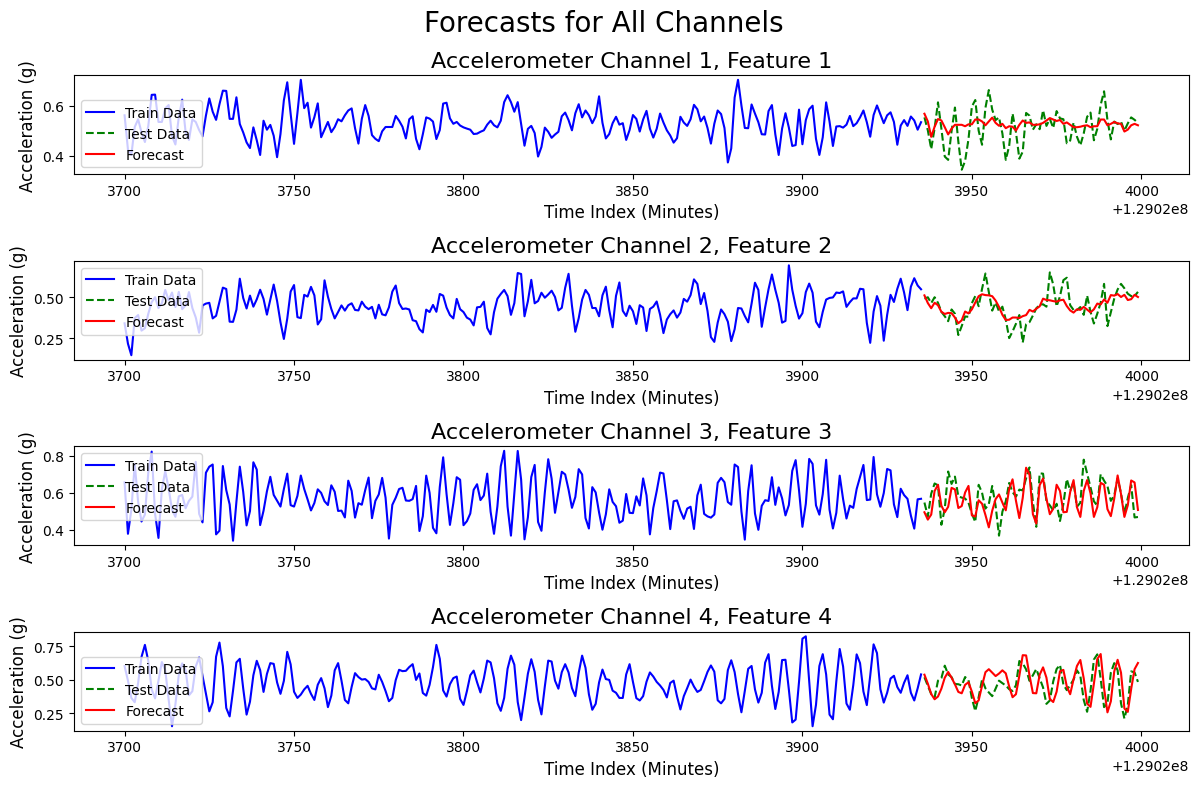

In [18]:
# Prepara i dati per il forecasting
context = torch.tensor(train_data3).float().T

# Esegui il forecasting
forecast_segment = pipeline_large.predict(
    context=context,
    prediction_length=NUM_TEST,
    num_samples=NUM_SAMPLES
)

forecasts = forecast_segment.numpy()

# Calcola le metriche usando la mediana
median_forecasts = np.median(forecasts, axis=1).T
actual = test_data3

mae = np.mean(np.abs(median_forecasts - actual), axis=0)
mse = np.mean((median_forecasts - actual) ** 2, axis=0)

print("Mean Absolute Error (MAE) per canale:")
for i, mae_value in enumerate(mae):
    print(f"Channel {i+1}: {mae_value}")

print("\nMean Squared Error (MSE) per canale:")
for i, mse_value in enumerate(mse):
    print(f"Channel {i+1}: {mse_value}")


# Crea i grafici per tutti i canali
plot_forecast_all_channels_single(train_data3, test_data3, forecasts)